In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn statsmodels

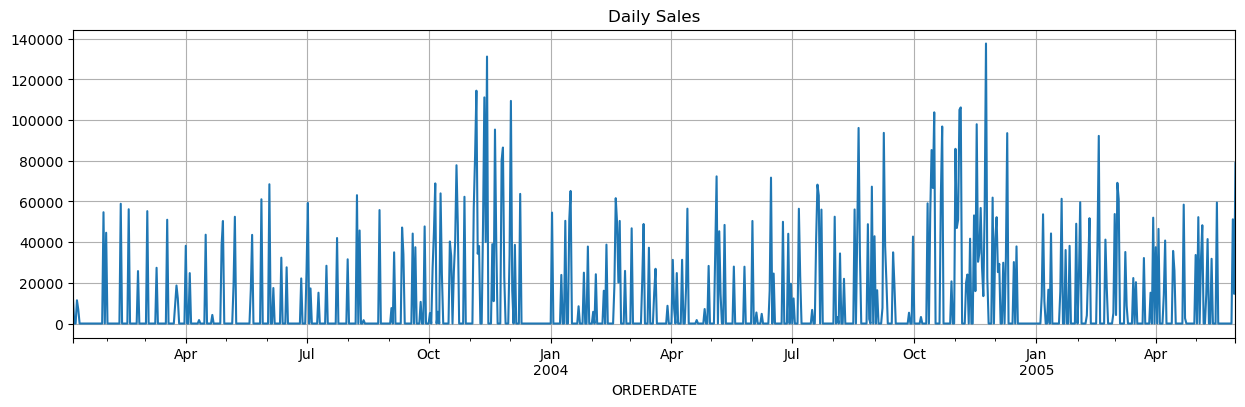

ADF Statistic: -4.991792629134438
p-value: 2.3038352165227456e-05


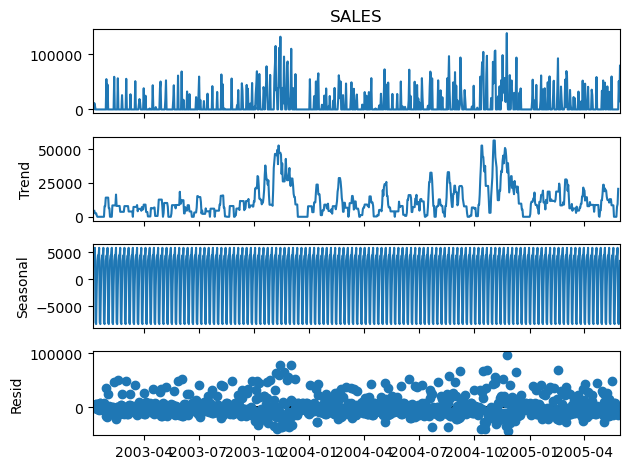

ARIMA - MAE: 17957.62, RMSE: 23537.12
Random Forest - MAE: 3070.74, RMSE: 3747.32


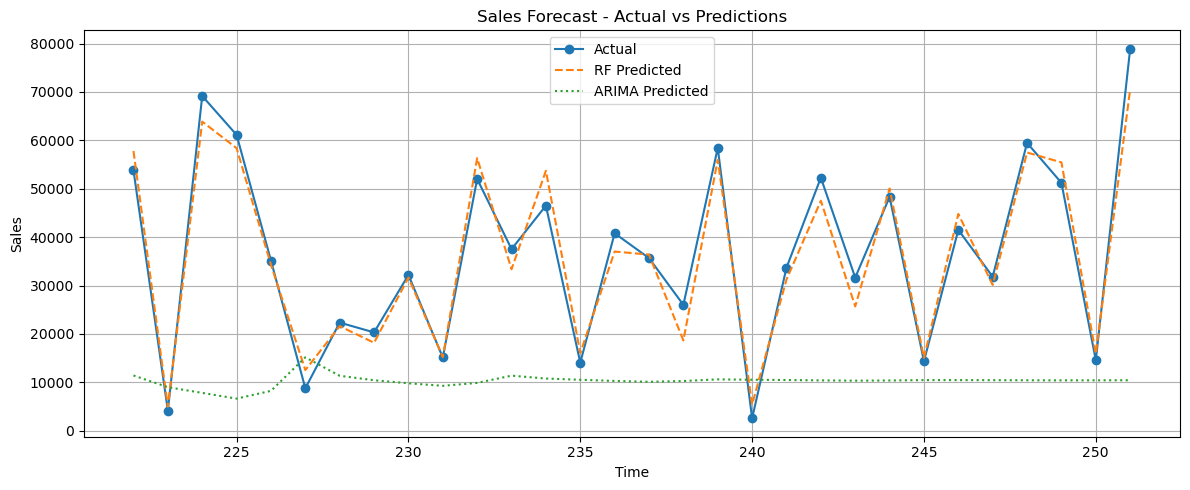

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

# 2. Load and Preprocess Data
df = pd.read_csv("sales_data_sample.csv", encoding='latin1')  # Adjust the file path

df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df.sort_values('ORDERDATE', inplace=True)
df['SALES'] = pd.to_numeric(df['SALES'], errors='coerce')
df.dropna(subset=['SALES'], inplace=True)

# 3. Time Series Aggregation
ts = df.groupby('ORDERDATE')['SALES'].sum().asfreq('D').fillna(0)

# 4. Visual Inspection
ts.plot(figsize=(15, 4), title="Daily Sales")
plt.grid(True)
plt.show()

# 5. Check Stationarity
result = adfuller(ts)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# 6. Decomposition
decompose_result = seasonal_decompose(ts, model='additive')
decompose_result.plot()
plt.tight_layout()
plt.show()

# 7. Train-Test Split
train = ts[:-30]
test = ts[-30:]

# 8. ARIMA Forecasting
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=30)

# 9. ARIMA Evaluation
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA - MAE: {arima_mae:.2f}, RMSE: {arima_rmse:.2f}")

# 10. Feature Engineering for ML
df['DAY'] = df['ORDERDATE'].dt.day
df['MONTH'] = df['ORDERDATE'].dt.month
df['YEAR'] = df['ORDERDATE'].dt.year
df['DAYOFWEEK'] = df['ORDERDATE'].dt.dayofweek

df_ml = df.groupby('ORDERDATE').agg({
    'SALES': 'sum',
    'QUANTITYORDERED': 'sum',
    'PRICEEACH': 'mean',
    'MSRP': 'mean',
    'MONTH_ID': 'first',
    'YEAR_ID': 'first',
    'DAY': 'first',
    'DAYOFWEEK': 'first'
}).reset_index()

# 11. Random Forest Regressor
X = df_ml.drop(columns=['ORDERDATE', 'SALES'])
y = df_ml['SALES']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=30)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 12. RF Evaluation
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest - MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")

# 13. Visualization
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test.values, label="Actual", marker='o')
plt.plot(y_test.index, y_pred_rf, label="RF Predicted", linestyle='--')
plt.plot(y_test.index, arima_forecast.values, label="ARIMA Predicted", linestyle=':')
plt.title("Sales Forecast - Actual vs Predictions")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()